In [1]:
import os
import sys
from sys import platform
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
BASE_PATH = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1])
sys.path.append(BASE_PATH+'\src' if platform == 'win32' else BASE_PATH+'/src')
from config.global_config import get_global_config
from utils import get_total_iterations

In [2]:
_config = get_global_config()
RESULTS_PATH = os.path.join(BASE_PATH, _config.get('RESULT_PATH_SHARED'))
if platform == 'win32':
	RESULTS_PATH = RESULTS_PATH.replace('/', '\\')
EMISSIONS_FILE = 'emissions.csv'
METRICS_FILE = 'metrics.csv'
PARAMS_FILE = 'params.csv'

In [3]:
experiments = []

for d in next(os.walk(RESULTS_PATH))[1]:
	for m in next(os.walk(RESULTS_PATH + d))[1]:
		experiments.append(os.path.join(d, m))

experiments = sorted(experiments)
movielens = [e for e in experiments if 'movielens' in e]

results = {
	'emissions': [],
	'duration': [],
	'cpu_power': [], 'gpu_power': [], 'ram_power': []
}
metrics = {
	'recall@10': [],
	'ndcg@10': [],
	'averagepopularity@10': [],
	'giniindex@10': []
}

In [4]:
print(''.join(['> ' for i in range(40)]))
print(f'\n{"ID":<5}{"DATASET":<18}{"MODEL":<12}{"DURATION(h)":>15}{"EMISSIONS(g)":>18}\n')
print(''.join(['> ' for i in range(40)]))
for i, v in enumerate(movielens):
	e = pd.read_csv(os.path.join(RESULTS_PATH, v, EMISSIONS_FILE))
	m = pd.read_csv(os.path.join(RESULTS_PATH, v, METRICS_FILE))
	for k in results.keys():
		if k == 'emissions':
			results[k].append(e.iloc[0][k]*1000)
		else:
			results[k].append(e.iloc[0][k])
	for k in metrics.keys():
		metrics[k].append(m.iloc[0][k])
	print(f'{i+1:<5}{v.split("/")[0]:<18}{v.split("/")[1]:<12}{str(datetime.timedelta(seconds=int(e.iloc[0]["duration"]))):>15}{e.iloc[0]["emissions"]*1000:>18.5f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

ID   DATASET           MODEL           DURATION(h)      EMISSIONS(g)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
1    movielens_1m      BPR                 0:01:03           0.02731
2    movielens_1m      CDAE                0:00:53           0.01886
3    movielens_1m      CFKG                0:02:49           0.09618
4    movielens_1m      CKE                 0:06:03           0.22309
5    movielens_1m      ConvNCF             7:32:20          11.32026
6    movielens_1m      DGCF                3:12:04           8.32166
7    movielens_1m      DMF                 0:06:25           0.22655
8    movielens_1m      DiffRec             0:01:48           0.04726
9    movielens_1m      EASE                0:00:24           0.00077
10   movielens_1m      ENMF                0:01:06           0.02620
11   movielens_1m      FISM                0:44:42           1.35577
12   mov

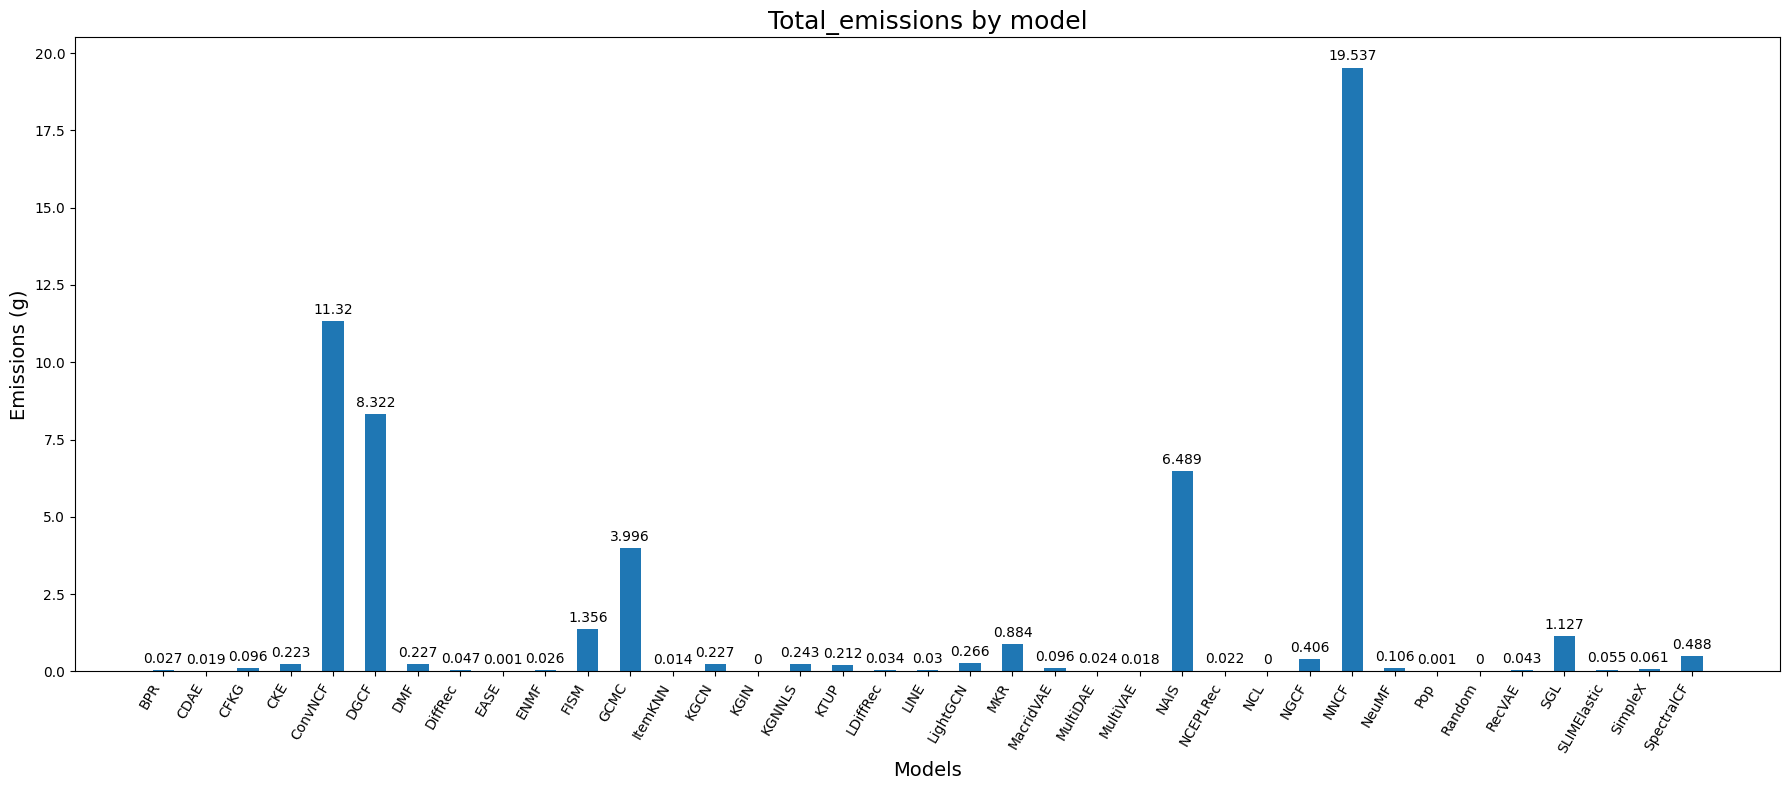

In [5]:
labels_x2 = [l.split('/')[1] for l in movielens]
features_to_plot2 = {'total_emissions': results['emissions']}

x1 = np.arange(len(labels_x2))  # the label locations
width = 0.5  # the width of the bars
multiplier = 0

fig, ax1 = plt.subplots(1, 1, figsize=(18, 8))
for i, v in enumerate(features_to_plot2.keys()):
    for attribute, measurement in [(v, features_to_plot2[v])]:
        offset = width * multiplier
        rects = ax1.bar(x1 + offset, [round(i, 3) for i in measurement], width, label = attribute)
        ax1.bar_label(rects, padding = 3)
        multiplier += 1
    ax1.set_xlabel('Models', fontsize=14)
    ax1.set_ylabel('Emissions (g)', fontsize=14)
    ax1.set_title(v.capitalize() + ' by model', fontsize=18)
    ax1.set_xticks(x1 + (i / 2), labels_x2, rotation = 60, ha="right")

fig.tight_layout()
plt.show()

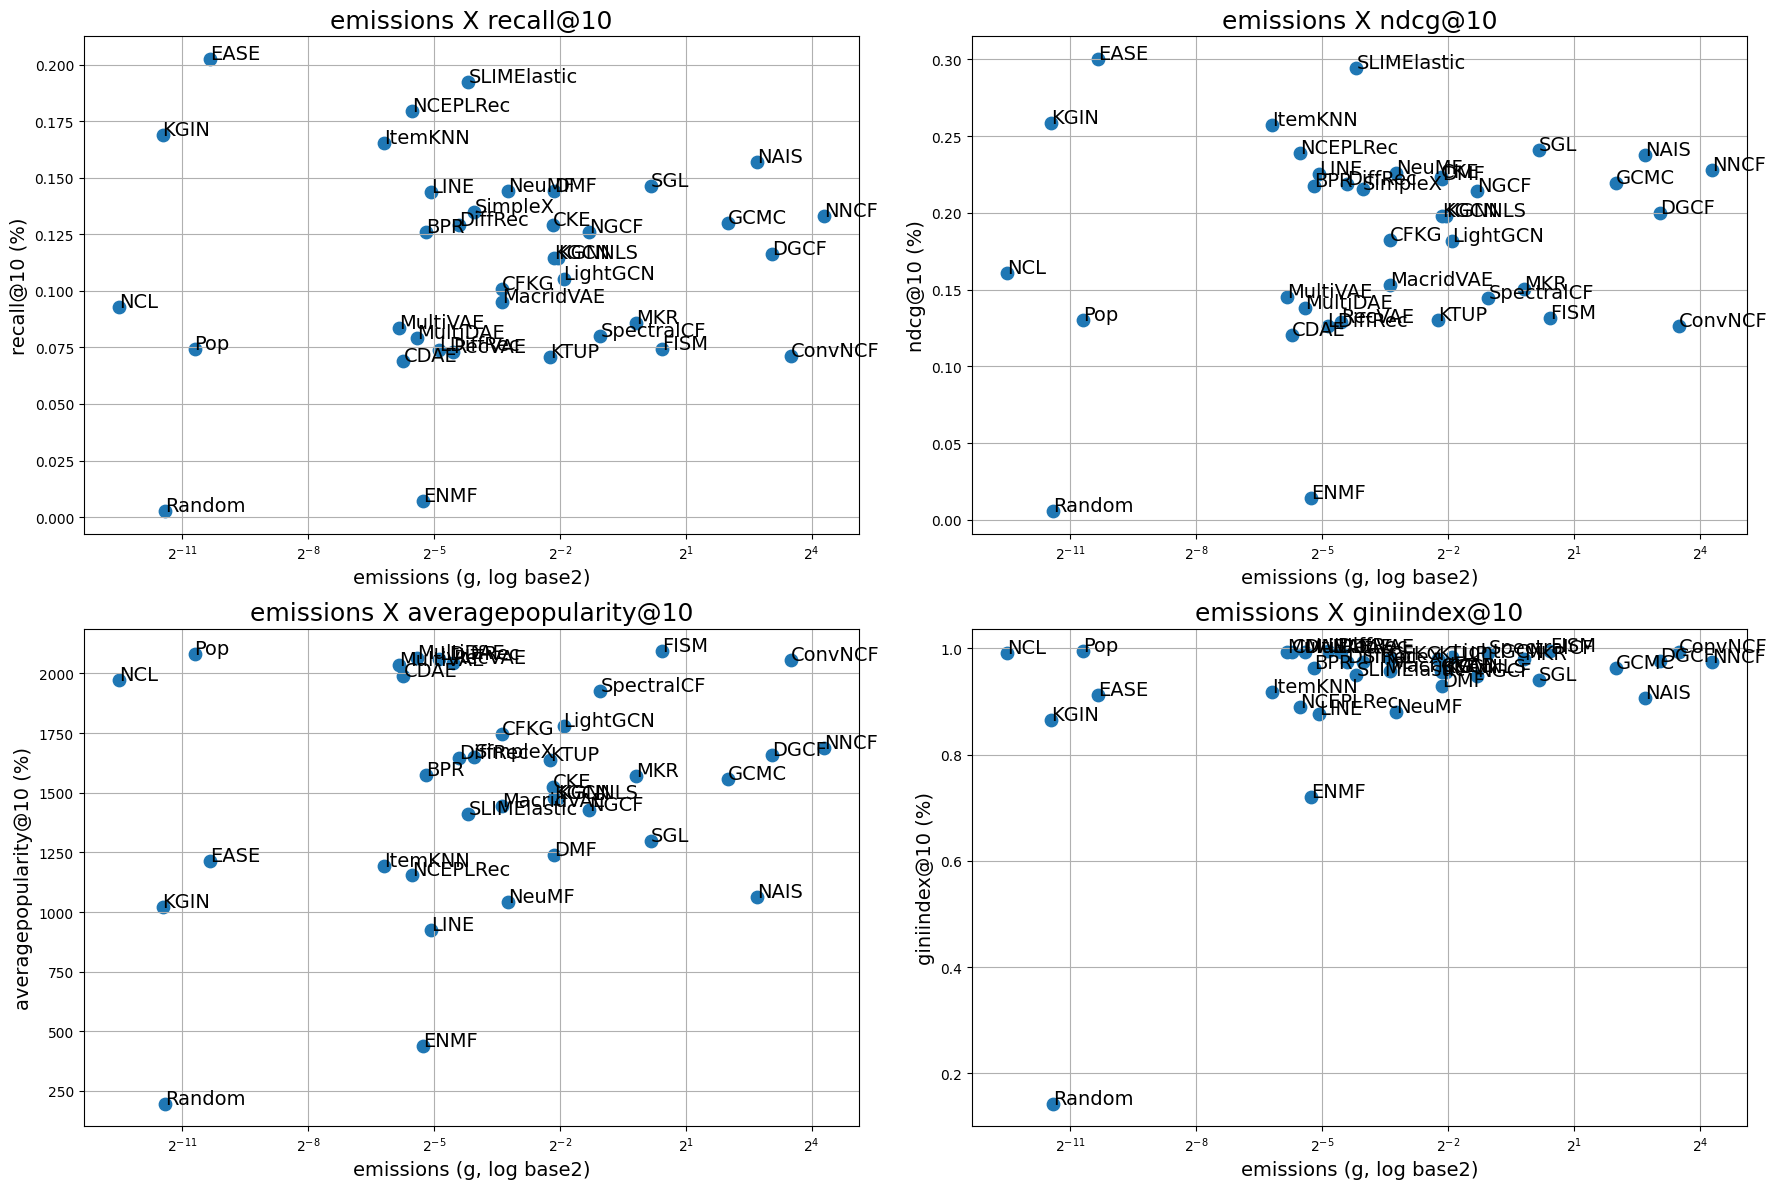

In [6]:
counter = 0
l = [
	['emissions','recall@10'],['emissions','ndcg@10'],['emissions','averagepopularity@10'],['emissions','giniindex@10']
]

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
for _, axl in enumerate(axs):
	for _, ax in enumerate(axl):
		ax.scatter(results[l[counter][0]], metrics[l[counter][1]], s=80)
		ax.set_title(l[counter][0]+' X '+l[counter][1], fontsize=18)
		ax.set_xlabel(l[counter][0] + ' (g, log base2)', fontsize=14)
		ax.set_ylabel(l[counter][1] + ' (%)', fontsize=14)
		ax.grid()
		for i, (xi, yi) in enumerate(zip(results[l[counter][0]], metrics[l[counter][1]])):
			ax.text(xi, yi, experiments[i].split('/')[1], fontsize=14)
		ax.set_xscale('log', base=2)
		counter = counter + 1
fig.tight_layout()
plt.show()

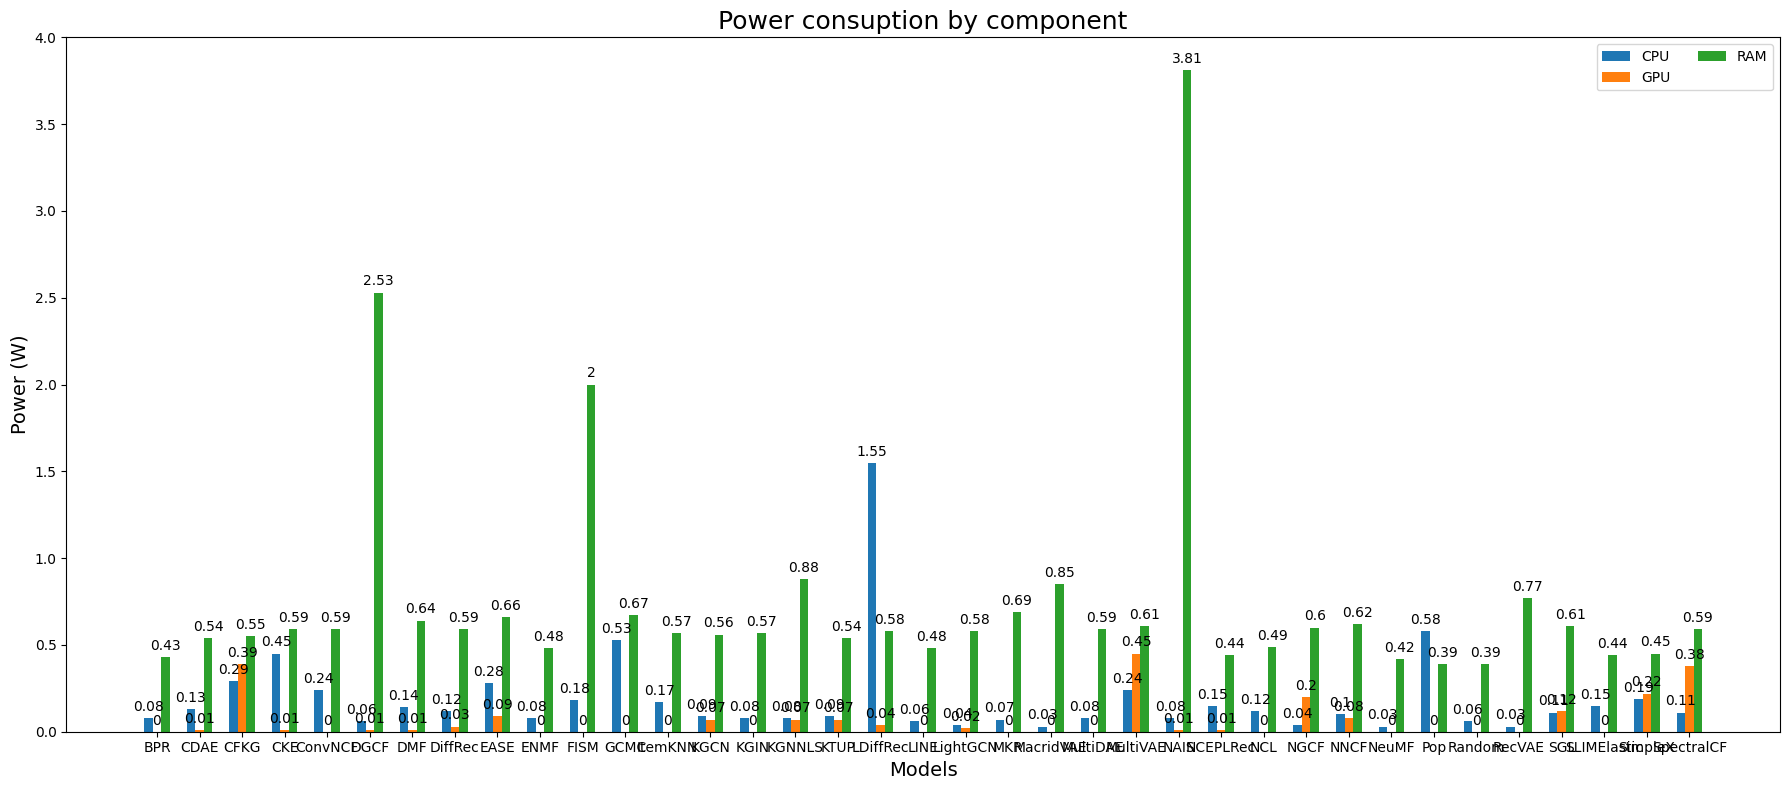

In [7]:
labels_x1 = [l.split('/')[1] for l in movielens]
features_to_plot1 = {'CPU': results['cpu_power'], 'GPU': results['gpu_power'], 'RAM': results['ram_power']}

x1 = np.arange(len(labels_x1))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax1 = plt.subplots(1, 1, figsize=(18, 8))

for attribute, measurement in features_to_plot1.items():
    offset = width * multiplier
    rects = ax1.bar(x1 + offset, [round(i, 2) for i in measurement], width, label = attribute)
    ax1.bar_label(rects, padding = 3)
    multiplier += 1
ax1.set_xlabel('Models', fontsize=14)
ax1.set_ylabel('Power (W)', fontsize=14)
ax1.set_title('Power consuption by component', fontsize=18)
ax1.set_xticks(x1 + (width), labels_x1)
ax1.legend(loc = 'upper right', ncol = 2)

fig.tight_layout()
plt.show()